# WEC AC Injection

### Imports

In [1]:
import os,sys
sys.path.append('../wec-grid-code') # 
import wec_grid_class as wg
import sqlite3
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

    Sets PSSE environment to latest minor version among installed versions of PSSE 35.
    Use psse35.set_minor(n) to set PSSE35 minor version (n) to use.
        Example, for PSSE 35.0.x, use this as: psse35.set_minor(0)


In [3]:
# Read in case file 
case14 = r"../input_files/RTS96DYN/IEEE_24_bus.RAW"

### run for DC 

In [ ]:
# initalize WEC GRID Object
pf = wg.Wec_grid(case14,"DC",3)

### run for AC 

In [4]:
# initalize WEC GRID Object
pf = wg.Wec_grid(case14,"fnsl",[2,13, 21])


 Input error detected at !
 -m ipykernel_launcher -f C:\Users\alexb\AppData\Roaming\jupyter\runtime\kernel-19ad6853-5cf1-4d1f-a8d5-7e75b155c2fc.json
                          !

 PSS(R)E Xplore Version 35
 Copyright (c) 1976-2023
 Siemens Industry, Inc.,
 Power Technologies International                            (PTI)
 This program is a confidential  unpublished  work  created  and  first
 licensed in 1976.  It is a trade secret which is the property of  PTI.
 All use,  disclosure,  and/or reproduction not specifically authorized
 by  PTI  is prohibited.   This  program is protected  under  copyright
 laws  of  non-U.S.  countries  and  by  application  of  international
 treaties.  All  Rights  Reserved  Under  The  Copyright  Laws.


           SIEMENS POWER TECHNOLOGIES INTERNATIONAL

    50 BUS POWER SYSTEM SIMULATOR--PSS(R)E Xplore-35.3.2

             INITIATED ON TUE, JAN 31 2023  15:12

 Reading IC, SBASE, REV, XFRRAT, NXFRAT, BASFRQ...

 Converting RAW data from PSS(R)E 33 

### Run WEC Model via matlab (takes a minute)

In [ ]:
os.remove("../input_files/WEC-SIM.db")
for i in range(1,4):
    pf.run_WEC_Sim(wec_id=i, sim_length=3600, Tsample=300, waveHeight=2.5, wavePeriod=8, waveSeed=np.random.randint(999999999))

In [ ]:
pf.dataframe.iloc[[0,1,12, 20]]

In [ ]:
pf.dataframe.iloc[[0,1,12, 20]]

### Pull WEC injection values via SQL database

In [ ]:
pf.dataframe

In [5]:
con = sqlite3.connect("../input_files/WEC-SIM.db")
wec_1 = pd.read_sql_query("SELECT * from WEC_output_1", con)
wec_2 = pd.read_sql_query("SELECT * from WEC_output_2", con)
wec_3 = pd.read_sql_query("SELECT * from WEC_output_3", con)
print(wec_1)
print(wec_2)
print(wec_3)

      time  ibus         pg   vs         pt   pb         qt         qb
0      0.0   1.0   0.000000  1.0   0.000000  0.0   0.000000   0.000000
1    450.0   1.0  17.403288  1.1  17.403288  0.0  57.381576 -57.381576
2    750.0   1.0  16.383323  1.1  16.383323  0.0  57.687683 -57.687683
3   1050.0   1.0  14.959421  1.1  14.959421  0.0  58.095496 -58.095496
4   1350.0   1.0  17.535634  1.1  17.535634  0.0  57.343608 -57.343608
5   1650.0   1.0  15.340464  1.1  15.340464  0.0  57.990185 -57.990185
6   1950.0   1.0  13.505177  1.1  13.505177  0.0  58.437377 -58.437377
7   2250.0   1.0  16.436120  1.1  16.436120  0.0  57.688844 -57.688844
8   2550.0   1.0  21.864381  1.1  21.864381  0.0  55.820973 -55.820973
9   2850.0   1.0  19.760218  1.1  19.760218  0.0  56.533920 -56.533920
10  3150.0   1.0  12.375984  1.1  12.375984  0.0  58.693548 -58.693548
11  3450.0   1.0  19.598362  1.1  19.598362  0.0  56.630348 -56.630348
      time  ibus         pg   vs         pt   pb         qt         qb
0     

In [6]:
wecs_buses = [2,13, 21]
for i in range(len(wec_1)):
#     print("Time: {}".format(injection.iloc[i].time))
#     print("P setpoint: {}".format(injection.pg.iloc[i]))
    p = [wec_1.iloc[i].pg, wec_2.iloc[i].pg, wec_3.iloc[i].pg]
    v = [wec_1.iloc[i].vs, wec_2.iloc[i].vs, wec_3.iloc[i].vs]
    pf.ac_injection(p, v, pf.solver, wec_1.iloc[i].time)
    print(pf.dataframe.iloc[[0,1,12,20]])
    print("========================")


 Power flow data changed for machine "1" at bus 2 [2           138.00]:
 X--ORIGINAL--X  X-NEW VALUE--X  DATA ITEM
    67.0000         0.00000      PG

 Power flow data changed for bus 2 [2           138.00]:
 X--ORIGINAL--X  X-NEW VALUE--X  DATA ITEM
   0.997822         1.00000      VM

 Power flow data changed for machine "1" at bus 13 [13          230.00]:
 X--ORIGINAL--X  X-NEW VALUE--X  DATA ITEM
    200.000         0.00000      PG

 Power flow data changed for bus 13 [13          230.00]:
 X--ORIGINAL--X  X-NEW VALUE--X  DATA ITEM
   0.836927         1.00000      VM

 Power flow data changed for machine "1" at bus 21 [21          230.00]:
 X--ORIGINAL--X  X-NEW VALUE--X  DATA ITEM
    294.000         0.00000      PG

 Power flow data changed for bus 21 [21          230.00]:
 X--ORIGINAL--X  X-NEW VALUE--X  DATA ITEM
   0.911253         1.00000      VM

  ITER       DELTAP      BUS         DELTAQ      BUS        DELTA/V/      BUS       DELTAANG      BUS
   0         4.6851(     2

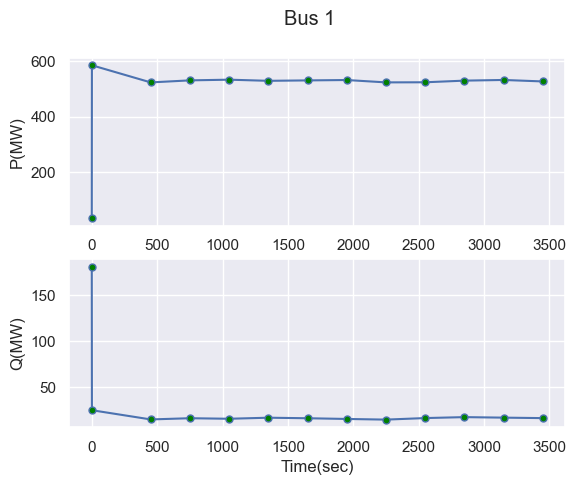

In [7]:
pf.plot_bus(1)

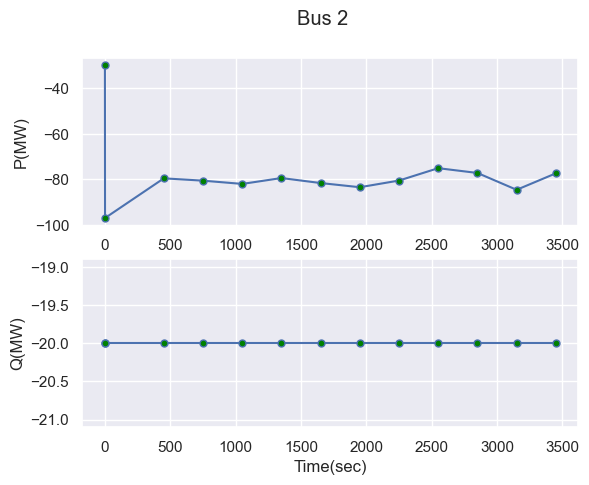

     time  BUS_ID    Bus   BASE        PU    ANGLED  Type      P Gen  Q Gen  \
1    -1.0       2  BUS 2  138.0  0.997822  0.010373     2  67.000000    0.0   
1     0.0       2  BUS 2  138.0  0.996641 -0.214100     2   0.000000    0.0   
1   450.0       2  BUS 2  138.0  0.996967 -0.189738     2  17.403288    0.0   
1   750.0       2  BUS 2  138.0  0.996931 -0.192215     2  16.383324    0.0   
1  1050.0       2  BUS 2  138.0  0.996922 -0.193588     2  14.959422    0.0   
1  1350.0       2  BUS 2  138.0  0.996937 -0.191209     2  17.535633    0.0   
1  1650.0       2  BUS 2  138.0  0.996928 -0.192603     2  15.340466    0.0   
1  1950.0       2  BUS 2  138.0  0.996922 -0.193827     2  13.505177    0.0   
1  2250.0       2  BUS 2  138.0  0.996964 -0.190173     2  16.436121    0.0   
1  2550.0       2  BUS 2  138.0  0.996972 -0.187928     2  21.864382    0.0   
1  2850.0       2  BUS 2  138.0  0.996939 -0.190447     2  19.760218    0.0   
1  3150.0       2  BUS 2  138.0  0.996907 -0.194222 

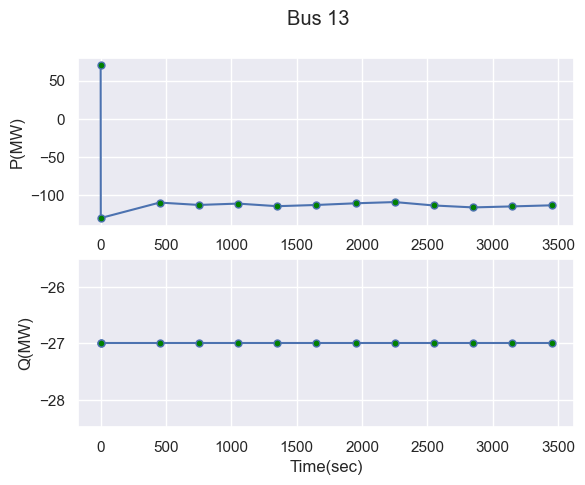

      time  BUS_ID     Bus   BASE        PU     ANGLED  Type       P Gen  \
12    -1.0      13  BUS 13  230.0  0.836927  15.450583     2  200.000000   
12     0.0      13  BUS 13  230.0  0.892299 -12.434435     2    0.000000   
12   450.0      13  BUS 13  230.0  0.897992 -10.158784     2   20.217775   
12   750.0      13  BUS 13  230.0  0.897187 -10.486691     2   17.114531   
12  1050.0      13  BUS 13  230.0  0.897697 -10.503902     2   18.877283   
12  1350.0      13  BUS 13  230.0  0.896717 -10.492905     2   15.476429   
12  1650.0      13  BUS 13  230.0  0.897163 -10.436124     2   17.086676   
12  1950.0      13  BUS 13  230.0  0.897765 -10.379726     2   19.273359   
12  2250.0      13  BUS 13  230.0  0.898129 -10.110314     2   20.886833   
12  2550.0      13  BUS 13  230.0  0.896982 -10.436923     2   16.410852   
12  2850.0      13  BUS 13  230.0  0.896319 -10.645486     2   13.887006   
12  3150.0      13  BUS 13  230.0  0.896592 -10.408494     2   15.202409   
12  3450.0  

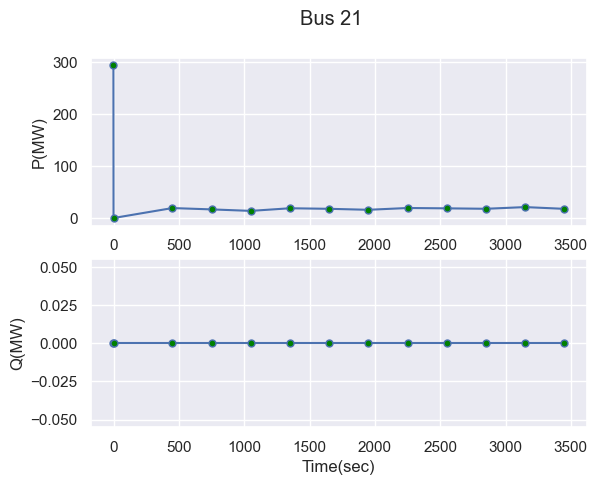

      time  BUS_ID     Bus   BASE        PU     ANGLED  Type       P Gen  \
20    -1.0      21  BUS 21  230.0  0.911253  35.657959     2  294.000000   
20     0.0      21  BUS 21  230.0  0.949573  -1.322708     2    0.000000   
20   450.0      21  BUS 21  230.0  0.951719   1.207723     2   19.152390   
20   750.0      21  BUS 21  230.0  0.951422   0.853733     2   16.585934   
20  1050.0      21  BUS 21  230.0  0.951612   0.693138     2   13.709405   
20  1350.0      21  BUS 21  230.0  0.951248   0.963512     2   18.784336   
20  1650.0      21  BUS 21  230.0  0.951413   0.946139     2   17.714577   
20  1950.0      21  BUS 21  230.0  0.951636   0.886107     2   15.816641   
20  2250.0      21  BUS 21  230.0  0.951766   1.247472     2   19.268276   
20  2550.0      21  BUS 21  230.0  0.951346   0.992509     2   18.608017   
20  2850.0      21  BUS 21  230.0  0.951103   0.807774     2   17.771231   
20  3150.0      21  BUS 21  230.0  0.951198   1.136409     2   21.027657   
20  3450.0  

In [8]:
for bus in pf.wecBus_nums:
    pf.plot_bus(bus)
    print(pf.bus_history(bus))

In [ ]:
pf.bus_history(2)

In [ ]:
# Import seaborn
import seaborn as sns
import matplotlib.pyplot as plt

# Apply the default theme
sns.set_theme()

# Load an example dataset
tips = sns.load_dataset("tips")

# Create a visualization
#f, ax = plt.subplots(1, 2, sharey=True)
sns.relplot(data=pf.swingBus, x="time", y="P")
sns.relplot(data=pf.swingBus, x="time", y="Q")

In [ ]:
sns.relplot??

In [ ]:
pf.swingBus

In [ ]:
pf.swingBus['P']

In [ ]:
pf.dataframe.iloc[[1,2]]

In [ ]:
pf.history

In [ ]:
list(pf.swingBus['time'][0])[-1] + 100

In [ ]:
injection

In [ ]:
import numpy as np

In [ ]:
np.random.randint(999999999)

In [ ]:
import os, sys

In [ ]:
os.remove("../input_files/r2g_database.db")

In [ ]:
os.system??

In [ ]:
ls ../input_files/r2g_database.db

In [ ]:
conn = sqlite3.connect('../input_files/WEC-SIM.db')

In [ ]:
os.remove("../input_files/WEC-SIM.db")

In [ ]:
for idx, bus in enumerate(pf.wecBus_nums):
    print(bus)

In [ ]:
bus_num = 1
bus_dataframe = pd.DataFrame()
for time, df in pf.history.items():
    temp = pd.DataFrame(df.loc[df["BUS_ID"] == bus_num])
    temp.insert(0, 'time', time)
    bus_dataframe = bus_dataframe.append(temp)

In [ ]:
bus_dataframe

In [ ]:
temp

In [ ]:
fig, (ax1, ax2) = plt.subplots(2)

In [ ]:
ax1.set_ylim??